In [58]:
!pip install -q netCDF4
!pip install -q Metar

In [59]:
import os
import re

import datetime
import numpy as np
import pandas as pd
from urllib.request import urlopen

import netCDF4 as nc
from metar import Metar
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import joblib
from scipy import stats
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

from keras import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Preprocessing data

In [60]:
ds = nc.Dataset('data/air.2020.nc')

In [61]:
ds['air']

<class 'netCDF4._netCDF4.Variable'>
float32 air(time, level, lat, lon)
    long_name: daily mean 6-hourly Air Temperature on Pressure Levels
    units: degK
    precision: 2
    least_significant_digit: 1
    GRIB_id: 11
    GRIB_name: TMP
    var_desc: Air temperature
    dataset: NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Daily Averages
    level_desc: Pressure Levels
    statistic: Mean
    parent_stat: Individual Obs
    standard_name: air_temperature
    missing_value: -9.96921e+36
    valid_range: [137.5 362.5]
    actual_range: [185.575   315.09998]
unlimited dimensions: time
current shape = (305, 17, 73, 144)
filling on, default _FillValue of 9.969209968386869e+36 used

In [62]:
def get_noaa_lat_lng(coords):
    knn_labels = np.load('knn_labels.npy', allow_pickle=True).item()
    coords = np.array([coords[1], coords[0]]).reshape(1, -1)
    coord_idx = knn_labels.kneighbors(coords, return_distance=False)[0, 0]
    ## NOAA latitude goes from North To South
    X_noaa_lng = np.linspace(0, 360 -2.5, 144)
    Y_noaa_lat = np.linspace(90, -90, 73)

    lat = None
    lng = None
    y_idx = 0
    idx = 0
    for y in Y_noaa_lat:
        y_idx += 1
        x_idx = 0
        for x in X_noaa_lng:
            x_idx += 1
            if (coord_idx == idx):
                lat = y_idx
                lng = x_idx
                break
            idx += 1
        if lat is not None:
            break

    return lat, lng

In [63]:
coords = (10.96854, -74.78132)
lat, lng = get_noaa_lat_lng(coords)

In [64]:
data = ds['air'][0:304, 0, lat, lng].data

stats.describe(data)

DescribeResult(nobs=304, minmax=(298.55, 302.7), mean=300.8488, variance=0.5410295, skewness=-0.3281554877758026, kurtosis=0.05462318913839326)

## Parsing data (2015-2020)

In [65]:
data = []
for year in range(2015, 2021):
    ds = nc.Dataset(f"data/air.{year}.nc")
    limit = ds['air'].shape[0]
    for day, air in enumerate(ds['air'][0:limit, 0, lat, lng].data):
        date = datetime.datetime(year, 1, 1) + datetime.timedelta(day - 1)
        data.append([date, air])

In [66]:
df = pd.DataFrame(data=data, columns=['date', 'air'])
df.drop_duplicates()

df.reset_index(inplace=True)
df.set_index('date', inplace=True)

## Ploting rolling mean

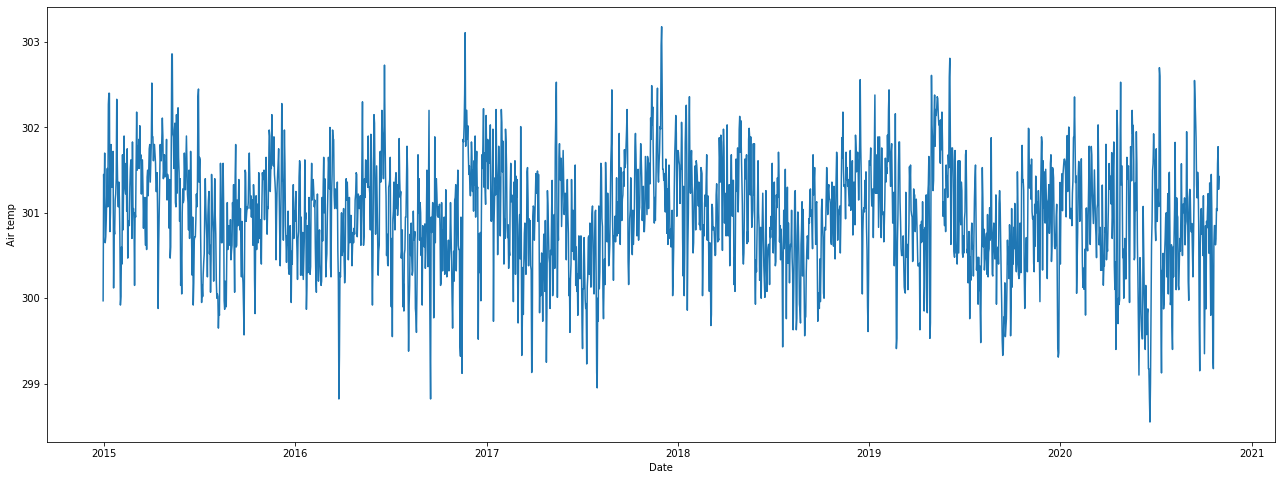

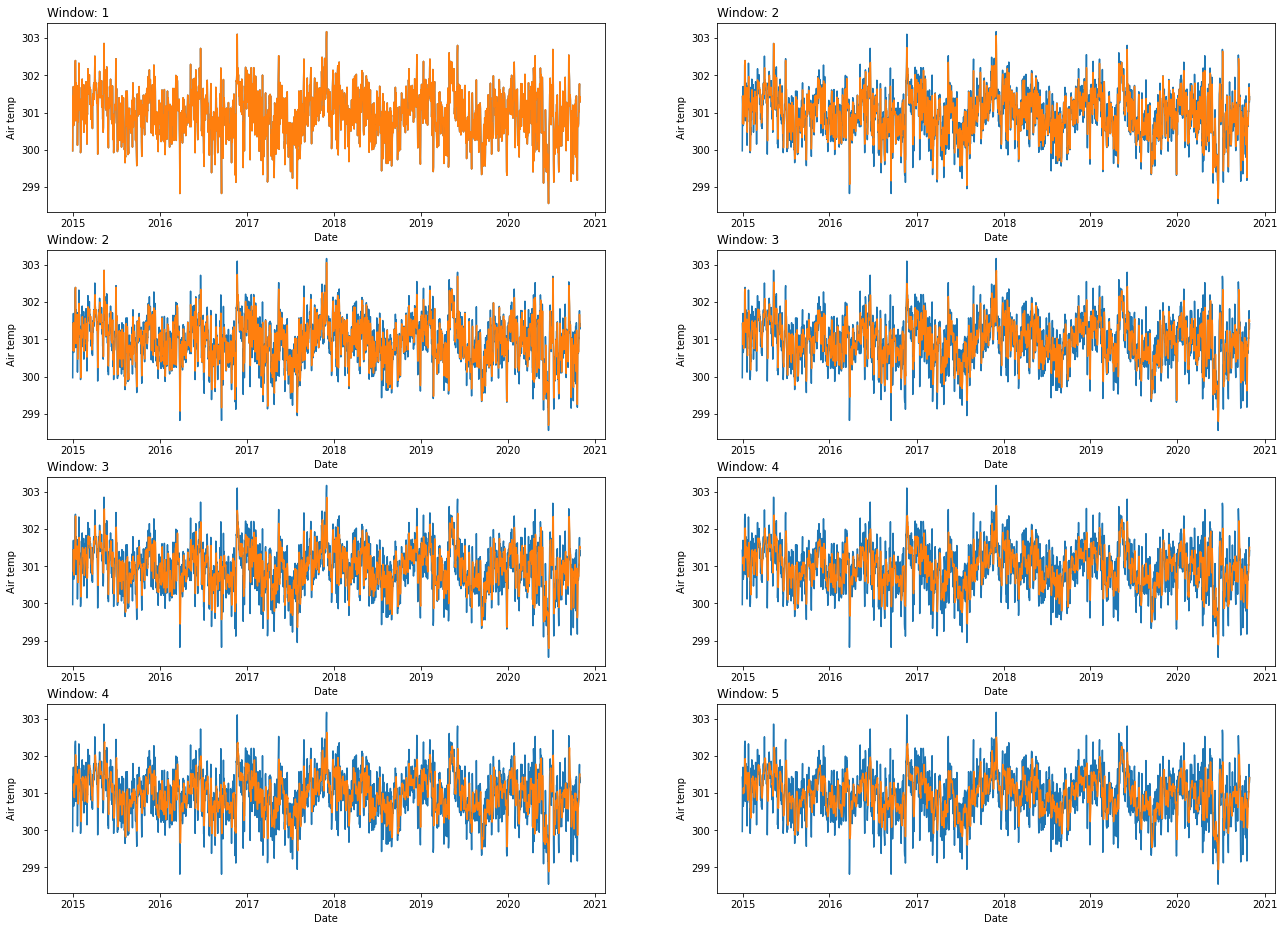

In [67]:
plt.figure(figsize=(22, 8))
plt.plot(df['air'])

plt.xlabel('Date')
plt.ylabel('Air temp')

plt.show()

fig, axs = plt.subplots(4, 2, figsize=(22, 16))

for axs_x in range(0, 4):
    for axs_y in range(0, 2):
        window = axs_x + axs_y + 1
        close_px = df['air']
        mavg = close_px.rolling(window=window).mean()
        
        axs[axs_x, axs_y].set_title(f"Window: {window}", loc='left')

        axs[axs_x, axs_y].plot(close_px, label='Data')
        axs[axs_x, axs_y].plot(mavg, label='mavg')
    
        axs[axs_x, axs_y].set(xlabel='Date', ylabel='Air temp')


## Converting dates

In [68]:
dates_df = df.copy()
dates_df = dates_df.reset_index()

dates_df['date'] = dates_df['date'].map(mdates.date2num)

dates_df.head()

,date,index,air
0,735598.0,0,299.970001
1,735599.0,1,301.450012
2,735600.0,2,301.200012
3,735601.0,3,301.700012
4,735602.0,4,300.649994


# Support Vector Regression

## Training

In [69]:
dates = dates_df['date'].values[0: -2].reshape(-1, 1)
air = df['air'].values[0: -2]

svr_rbf = SVR(kernel= 'rbf', C=1e3, gamma=0.1)
svr_rbf.fit(dates, air)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

## Forecast

In [70]:
last_date = dates_df['date'].values[-1].reshape(-1, 1)
last_air = df['air'].values[-1]

acc = abs(last_air - svr_rbf.predict(last_date)[0])

print(f"Accuracy for next value: {acc}")

Accuracy for next value: 0.4851888863078102


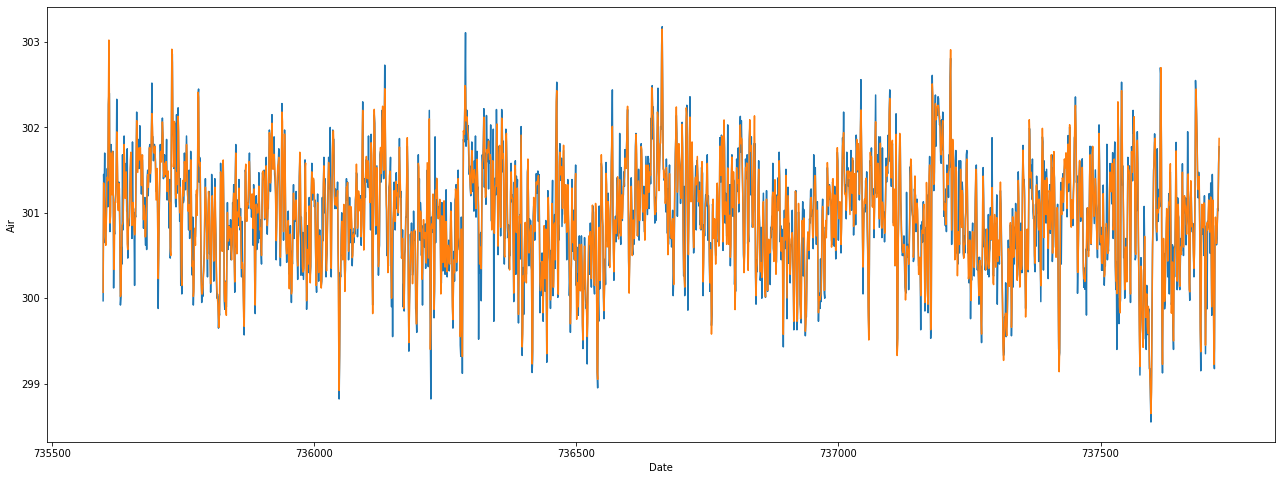

In [71]:
plt.figure(figsize=(22, 8))
plt.plot(dates, air, label='Data')

plt.plot(dates, svr_rbf.predict(dates), label='RBF model') 
plt.xlabel('Date')
plt.ylabel('Air')

plt.show()

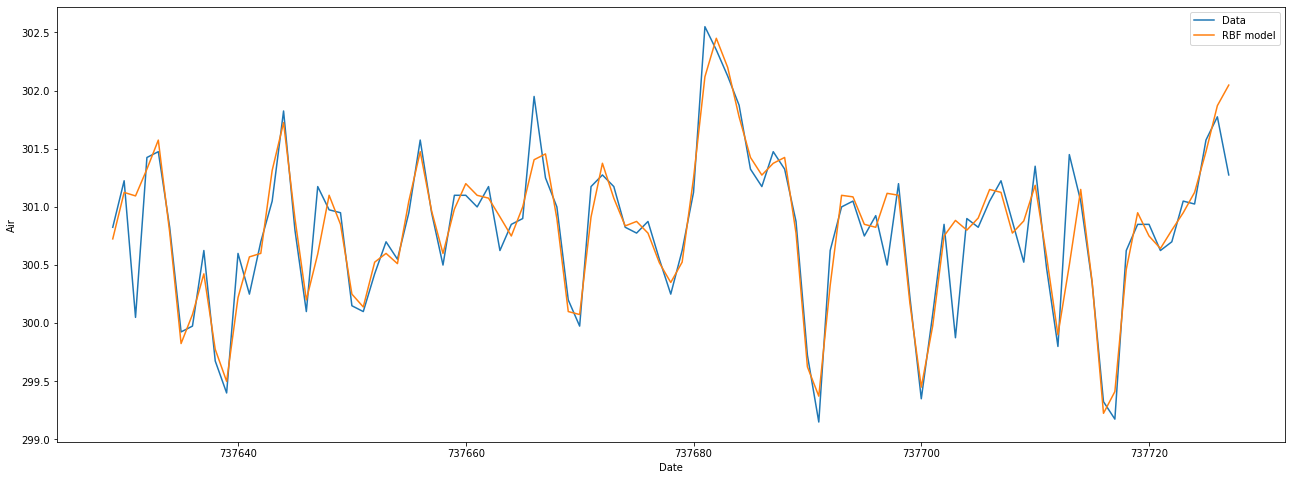

In [72]:
last_dates = dates_df['date'].values[-100:-1].reshape(-1, 1)
last_air_values = df['air'].values[-100:-1]

plt.figure(figsize=(22, 8))
plt.plot(last_dates, last_air_values, label='Data')
plt.plot(last_dates, svr_rbf.predict(last_dates), label='RBF model') 
plt.xlabel('Date')
plt.ylabel('Air')

plt.legend()
plt.show()

# Neuronal network

## Normalization

In [73]:
train_data = df['air'].values

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

## Create dataset

In [74]:
def create_dataset(dataset, time_steps):
    '''Function to create a dataset to feed into an LSTM. Returns X, Y'''
    X, Y = [], []
    for i in range(dataset.shape[0] - time_steps):
        X.append(dataset[i:(i + time_steps), 0])
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)


time_steps = 4
X_train, y_train = create_dataset(train_data, time_steps)

X_train = X_train.reshape(X_train.shape[0], time_steps, 1)

## Model

In [75]:
model = Sequential()

model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.4))

model.add(LSTM(units=100))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4, 100)            40800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 100)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


## Training

In [76]:
# Fitting the model to the Training set
hist = model.fit(X_train, y_train, epochs=20, batch_size=4, validation_split=.3)

Epoch 1/20
372/372 [==============================] - 3s 8ms/step - loss: 0.0227 - val_loss: 0.0184
Epoch 2/20
372/372 [==============================] - 2s 6ms/step - loss: 0.0185 - val_loss: 0.0177
Epoch 3/20
372/372 [==============================] - 2s 6ms/step - loss: 0.0173 - val_loss: 0.0185
Epoch 4/20
372/372 [==============================] - 2s 6ms/step - loss: 0.0159 - val_loss: 0.0165
Epoch 5/20
372/372 [==============================] - 2s 7ms/step - loss: 0.0152 - val_loss: 0.0184
Epoch 6/20
372/372 [==============================] - 2s 6ms/step - loss: 0.0145 - val_loss: 0.0145
Epoch 7/20
372/372 [==============================] - 2s 6ms/step - loss: 0.0142 - val_loss: 0.0137
Epoch 8/20
372/372 [==============================] - 2s 6ms/step - loss: 0.0134 - val_loss: 0.0145
Epoch 9/20
372/372 [==============================] - 2s 6ms/step - loss: 0.0134 - val_loss: 0.0138
Epoch 10/20
372/372 [==============================] - 2s 6ms/step - loss: 0.0136 - val_loss: 0.0134

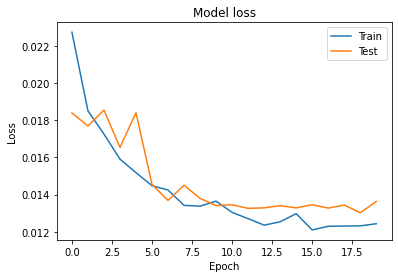

In [77]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show();

## Get last mont data

In [78]:
def fetch(url):
    try:
        html = urlopen(url).read()
        soup = BeautifulSoup(html, features='html.parser')
        for script in soup(["script", "style"]):
            script.extract()
        return soup
    except Exception:
        return None


def get_last_cortissoz_metars():
    now = datetime.datetime.utcnow()
    url = f"https://www.ogimet.com/display_metars2.php?lang=en&lugar=SKBQ&tipo=SA&ord=DIR&nil=NO&fmt=txt&ano={now.year}&mes={now.month}&day=1&hora=0&min=00&anof={now.year}&mesf={now.month}&dayf={now.day}&horaf={now.hour}&minf=59"
    soup = fetch(url)
    if soup is None:
        return []
    text = soup.get_text()
    if f"No hay METAR/SPECI de SKBQ en el periodo solicitado" in text:
        return []
    data = []
    text = re.sub('\s\s+', ' ', text)
    matches = re.findall(r"\s(\d+)[\s]METAR\s(.*)=", text)
    for match in matches:
        if ',' not in match:
            data.append(match)
    return data

def get_temperature(obs):
    """ returns temp K """
    return float(re.findall(r".*temperature:\s(.*)[\s]C\s*", obs)[0]) + 273.15

In [79]:
metars = get_last_cortissoz_metars()

last_data_df = []
for metar in metars:
    try:
        temp = 0.0
        obs = Metar.Metar(metar[1]).string()
        temp = get_temperature(obs)
        last_data_df.append([datetime.datetime.strptime(metar[0], '%Y%m%d%H%M'), temp])
    except Exception as e:
        str_err = str(e)
        if 'Unparsed groups' not in str_err and '_handleTime' not in str_err and '_handleWind' not in str_err and "NSW" not in str_err:
            print('index:', idx, 'error:', e)

last_data_df = pd.DataFrame(last_data_df, columns=['date', 'air'])

last_data_df.describe()

,air
count,621.000000
mean,300.009903
std,2.512168
min,296.150000
25%,298.150000
50%,299.150000
75%,302.150000
max,306.150000


## Evaluate

In [80]:
last_data_df['date'] = pd.to_datetime(last_data_df.date)
last_data_df = last_data_df.sort_values(by='date')

test_data = last_data_df['air'].values.reshape(-1,1)
test_data = scaler.transform(test_data)

time_steps = 4
X_test, y_test = create_dataset(test_data, time_steps)

y_test = y_test.reshape(-1,1)
y_true = scaler.inverse_transform(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], time_steps, 1))

model.evaluate(X_test, y_test)

20/20 [==============================] - 0s 4ms/step - loss: 0.0847


0.08470676094293594

## Predict

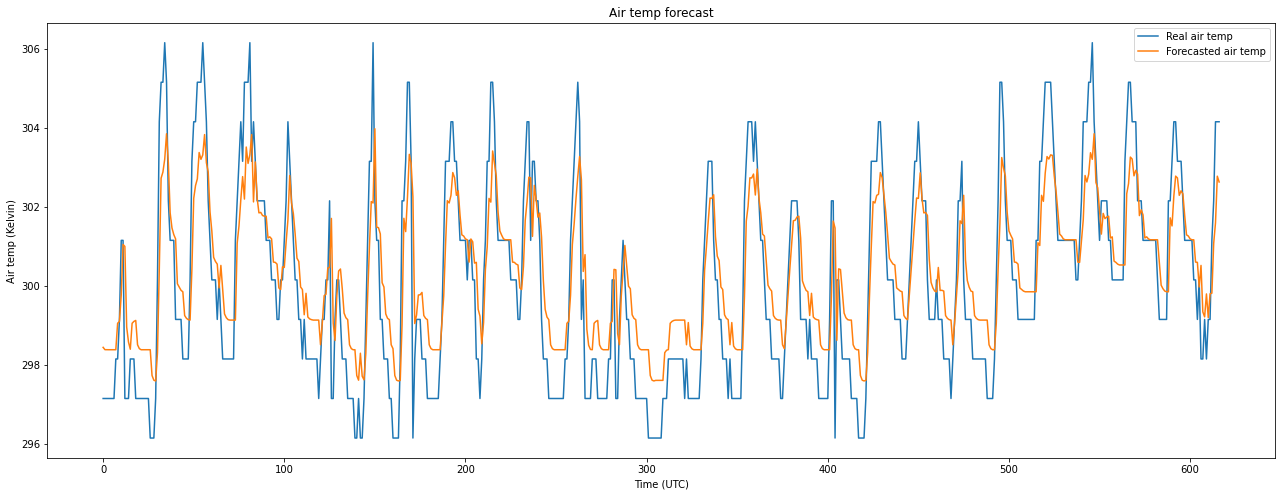

In [81]:
y_score = model.predict(X_test)
y_score = scaler.inverse_transform(y_score)

plt.figure(figsize=(22, 8))
plt.plot(y_true, label='Real air temp')
plt.plot(y_score, label='Forecasted air temp')
plt.title('Air temp forecast')
plt.xlabel('Time (UTC)')
plt.ylabel('Air temp (Kelvin)')
plt.legend()
plt.show()

## Re training

In [82]:
hist = model.fit(X_test, y_test, batch_size=4)

155/155 [==============================] - 1s 6ms/step - loss: 0.0711


## Save model

In [83]:
model.save('model.h5')
joblib.dump(scaler, "scaler.save")
df.to_csv('train_data.csv')